In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score

In [2]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

2024-07-06 10:20:16.818967: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-06 10:20:16.833246: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-06 10:20:16.981130: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-06 10:20:17.213866: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-06 10:20:17.436570: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registe

# Base

In [84]:
df_ratings = pd.read_csv('corporateCreditRatingWithFinancialRatios.csv')

In [85]:
input_columns = ['Current Ratio', 'Long-term Debt / Capital', 'Debt/Equity Ratio',
                 'Gross Margin', 'Operating Margin', 'EBIT Margin', 'EBITDA Margin',
                 'Pre-Tax Profit Margin', 'Net Profit Margin', 'Asset Turnover',
                 'ROE - Return On Equity', 'Return On Tangible Equity',
                 'ROA - Return On Assets', 'ROI - Return On Investment',
                 'Operating Cash Flow Per Share', 'Free Cash Flow Per Share']

# *Encoding*

A partir daqui, há uma diferenciação entre dois modelos testados, um com um neurônio na camada de saída (*label encoding*) e um com um neurônio por *rating* (*one hot encoding*).

In [86]:
# label_encoder_dict = {
#     "AAA": (round(0/25, 2), round(25/25, 2)),
#     "AA+": (round(1/25, 2), round(24/25, 2)),
#     "AA": (round(2/25, 2), round(23/25, 2)),
#     "AA-": (round(3/25, 2), round(22/25, 2)),
#     "A+": (round(4/25, 2), round(21/25, 2)),
#     "A": (round(5/25, 2), round(20/25, 2)),
#     "A-": (round(6/25, 2), round(19/25, 2)),
#     "BBB+": (round(7/25, 2), round(18/25, 2)),
#     "BBB": (round(8/25, 2), round(17/25, 2)),
#     "BBB-": (round(9/25, 2), round(16/25, 2)),
#     "BB+": (round(10/25, 2), round(15/25, 2)),
#     "BB": (round(11/25, 2), round(14/25, 2)),
#     "BB-": (round(12/25, 2), round(13/25, 2)),
#     "B+": (round(13/25, 2), round(12/25, 2)),
#     "B": (round(14/25, 2), round(11/25, 2)),
#     "B-": (round(15/25, 2), round(10/25, 2)),
#     "CCC+": (round(16/25, 2), round(9/25, 2)),
#     "CCC": (round(17/25, 2), round(8/25, 2)),
#     "CCC-": (round(18/25, 2), round(7/25, 2)),
#     "CC+": (round(19/25, 2), round(6/25, 2)),
#     "CC": (round(20/25, 2), round(5/25, 2)),
#     "CC-": (round(21/25, 2), round(4/25, 2)),
#     "C+": (round(22/25, 2), round(3/25, 2)),
#     "C": (round(23/25, 2), round(2/25, 2)),
#     "C-": (round(24/25, 2), round(1/25, 2)),
#     "D": (round(25/25, 2), round(0/25, 2))
# }

label_encoder_dict = {
    "AAA": (round(0/9, 2), round(9/9, 2)),
    "AA": (round(1/9, 2), round(8/9, 2)),
    "A": (round(2/9, 2), round(7/9, 2)),
    "BBB": (round(3/9, 2), round(6/9, 2)),
    "BB": (round(4/9, 2), round(5/9, 2)),
    "B": (round(5/9, 2), round(4/9, 2)),
    "CCC": (round(6/9, 2), round(3/9, 2)),
    "CC": (round(7/9, 2), round(2/9, 2)),
    "C": (round(8/9, 2), round(1/9, 2)),
    "D": (round(9/9, 2), round(0/9, 2))
}

encoder_descending = 1

label_decoder_dict = {}
for k in label_encoder_dict.keys():
    label_decoder_dict[label_encoder_dict[k][encoder_descending]] = k

In [87]:
df_ratings["Rating"] = df_ratings["Rating"].str.replace("+", "").str.replace("-", "")
df_ratings["Rating Encoded"] = df_ratings["Rating"].apply(lambda x: label_encoder_dict[x.strip()][encoder_descending])

In [88]:
encoder = OneHotEncoder(sparse=False)

# Remoção de *outliers* baseado em estudo prévio

In [90]:
# IQR
Q1 = df_ratings[input_columns].quantile(0.25)
Q3 = df_ratings[input_columns].quantile(0.75)
IQR = Q3 - Q1
df_ratings = df_ratings[~((df_ratings[input_columns] < (Q1 - 1.5 * IQR)) |(df_ratings[input_columns] > (Q3 + 1.5 * IQR))).any(axis=1)]

In [80]:
ranges = {
    "Current Ratio": (-5, 20),
    "Long-term Debt / Capital": (-7, 15),
    "Debt/Equity Ratio": (-200, 250),
    "Gross Margin": (-25, 150),
    "Operating Margin": (-250, 100),
    "EBIT Margin": (-200, 100),
    "EBITDA Margin": (-200, 100),
    "Pre-Tax Profit Margin": (-100, 150),
    "Net Profit Margin": (-150, 150),
    "Asset Turnover": (-10, 6),
    "ROE - Return On Equity": (-2500, 2500),
    "Return On Tangible Equity": (-2500, 2500),
    "ROA - Return On Assets": (-100, 80),
    "ROI - Return On Investment": (-250, 250),
    "Operating Cash Flow Per Share": (-80, 100),
    "Free Cash Flow Per Share": (-50, 50)
}

for column in input_columns:
    df_ratings.drop(df_ratings[(df_ratings[column] < ranges[column][0]) | (df_ratings[column] > ranges[column][1])].index, inplace=True)

In [91]:
len(df_ratings)

3726

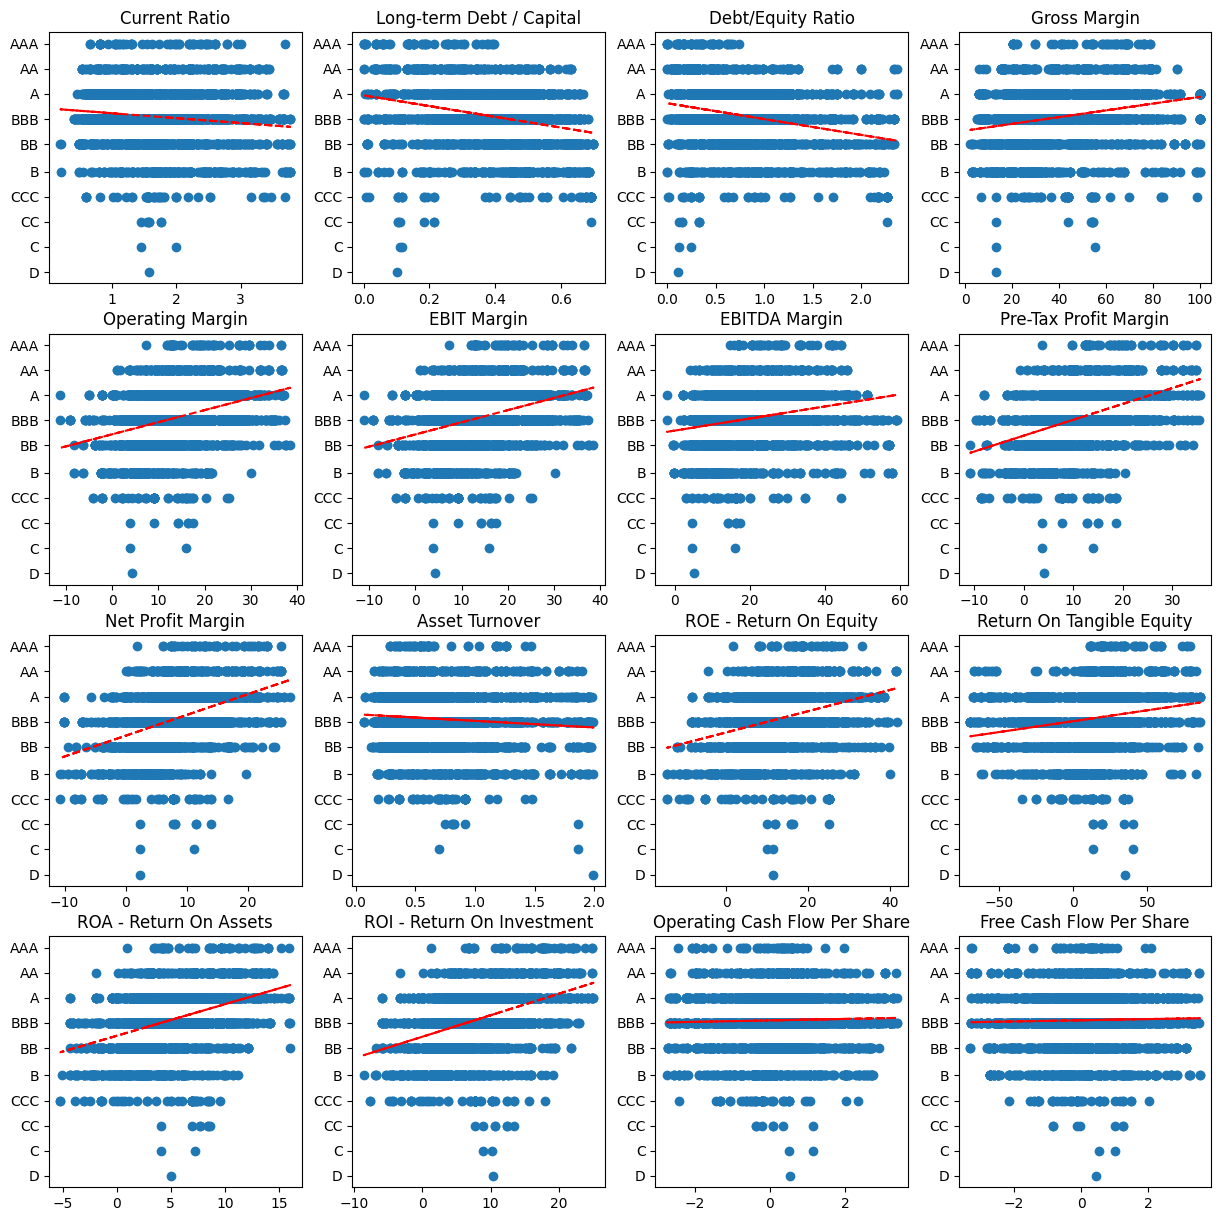

In [92]:
def subplot(ax, col):
    ax.scatter(df_ratings[[col]], df_ratings[['Rating Encoded']])
    coef = np.polyfit(df_ratings[col], df_ratings['Rating Encoded'], 1)
    poly1d_fn = np.poly1d(coef)
    ax.plot(df_ratings[col], poly1d_fn(df_ratings[col]), '--r')
    ax.set_title(col)

fig = plt.figure()
fig.set_figheight(15)
fig.set_figwidth(15)

k = 0

for i in range(4):
    for j in range(4):

        ax = plt.subplot2grid((4, 4), (i, j))
        # ticks_list = [1.0, 0.8, 0.6, 0.4, 0.2, 0]
        ticks_list = list(label_decoder_dict.keys())
        ax.set_yticks(ticks_list)
        ax.set_yticklabels([label_decoder_dict.get(i) for i in ticks_list])

        col = input_columns[k]
        subplot(ax, col)
        k += 1

plt.show()

In [93]:
df_relevant = df_ratings[input_columns + ['Rating Encoded']]
correlation_matrix = df_relevant.corr()

# Obter a correlação com a coluna de rating numérico
rating_correlation = correlation_matrix['Rating Encoded'].drop('Rating Encoded')

# Exibir os resultados
print("Correlação entre cada métrica financeira e o rating:")
# print(rating_correlation.sort_values())
df_rating_correlation = rating_correlation.to_frame()
df_rating_correlation['abs(Rating)'] = abs(df_rating_correlation['Rating Encoded'])
df_rating_correlation.sort_values('abs(Rating)', ascending=False).drop(columns=['abs(Rating)'])

Correlação entre cada métrica financeira e o rating:


,Rating Encoded
Pre-Tax Profit Margin,0.428184
Net Profit Margin,0.420268
ROI - Return On Investment,0.407836
ROA - Return On Assets,0.379421
EBIT Margin,0.338942
Operating Margin,0.336639
ROE - Return On Equity,0.316992
Long-term Debt / Capital,-0.272145
Debt/Equity Ratio,-0.262125
Gross Margin,0.243482


# Normalização

In [94]:
df_ratings[input_columns].describe()

,Current Ratio,Long-term Debt / Capital,Debt/Equity Ratio,Gross Margin,Operating Margin,EBIT Margin,EBITDA Margin,Pre-Tax Profit Margin,Net Profit Margin,Asset Turnover,ROE - Return On Equity,Return On Tangible Equity,ROA - Return On Assets,ROI - Return On Investment,Operating Cash Flow Per Share,Free Cash Flow Per Share
count,3726.000000,3726.000000,3726.000000,3726.000000,3726.000000,3726.000000,3726.000000,3726.000000,3726.000000,3726.000000,3726.000000,3726.000000,3726.000000,3726.000000,3726.000000,3726.000000
mean,1.629966,0.390081,0.826467,42.332916,13.793114,13.817750,21.540238,11.333490,8.058806,0.709989,12.743317,10.311643,4.935685,7.685368,0.229000,0.068610
std,0.742900,0.150058,0.489571,21.381986,8.245445,8.253289,11.273158,7.996272,5.990779,0.402526,8.843269,27.371539,3.558209,5.600738,1.139829,1.234548
min,0.208100,0.000400,0.000700,2.118800,-11.175700,-11.175700,-2.046300,-10.840600,-10.684000,0.068400,-14.431500,-69.742200,-5.194700,-8.534400,-2.737900,-3.295300
25%,1.029425,0.286600,0.464125,24.998500,7.547200,7.547200,12.726500,5.773275,4.183100,0.395600,7.491800,-4.022475,2.568525,4.123300,-0.346300,-0.630700
50%,1.520600,0.406450,0.752600,39.635600,12.962400,12.962400,19.143000,10.308150,7.357100,0.632600,11.893400,11.865750,4.392800,6.856400,0.201900,0.078200
75%,2.104975,0.494250,1.092125,59.117750,19.152700,19.178800,29.485850,16.552300,11.870950,0.917600,17.845300,24.652900,7.091000,11.065000,0.854700,0.753275
max,3.766300,0.698500,2.364500,100.000000,38.481100,38.481100,59.181300,35.569600,26.883700,1.994000,41.648800,85.578300,16.050800,25.024300,3.370000,3.530200


In [95]:
df_train = df_ratings[input_columns].copy().reset_index(drop=True)
# df_train.iloc[:, 0:-1] = StandardScaler().fit_transform(df_train.iloc[:, 0:-1].to_numpy())
df_train.iloc[:, 0:-1] = MinMaxScaler().fit_transform(df_train.iloc[:, 0:-1].to_numpy())

In [96]:
df_train.describe()

,Current Ratio,Long-term Debt / Capital,Debt/Equity Ratio,Gross Margin,Operating Margin,EBIT Margin,EBITDA Margin,Pre-Tax Profit Margin,Net Profit Margin,Asset Turnover,ROE - Return On Equity,Return On Tangible Equity,ROA - Return On Assets,ROI - Return On Investment,Operating Cash Flow Per Share,Free Cash Flow Per Share
count,3726.000000,3726.000000,3726.000000,3726.000000,3726.000000,3726.000000,3726.000000,3726.000000,3726.000000,3726.000000,3726.000000,3726.000000,3726.000000,3726.000000,3726.000000,3726.000000
mean,0.399603,0.558203,0.349339,0.410846,0.502828,0.503324,0.385227,0.477785,0.498907,0.333189,0.484570,0.515411,0.476825,0.483325,0.485748,0.068610
std,0.208785,0.214952,0.207112,0.218448,0.166049,0.166207,0.184119,0.172296,0.159466,0.209039,0.157689,0.176226,0.167481,0.166894,0.186616,1.234548
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.295300
25%,0.230826,0.409970,0.196051,0.233750,0.377046,0.377046,0.241277,0.357979,0.395742,0.169921,0.390927,0.423123,0.365406,0.377181,0.391558,-0.630700
50%,0.368866,0.581650,0.318090,0.383289,0.486099,0.486099,0.346074,0.455692,0.480229,0.293000,0.469414,0.525416,0.451272,0.458623,0.481311,0.078200
75%,0.533100,0.707420,0.461725,0.582328,0.610760,0.611286,0.514999,0.590234,0.600381,0.441005,0.575546,0.607744,0.578273,0.584033,0.588189,0.753275
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.530200


# Amostras de treino e de teste

In [97]:
X = df_train[input_columns]

y = df_ratings['Rating Encoded']
y_one_hot = encoder.fit_transform(df_ratings[['Rating']])

/home/cmore/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_one_hot, X_test_one_hot, y_train_one_hot, y_test_one_hot = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)

# Treinamento

In [99]:
# Uma saída

model_1 = Sequential([
    Dense(64, activation='relu', input_dim=len(X_train.columns)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_1.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

model_1.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

/home/cmore/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0140 - loss: 0.6446 - val_accuracy: 0.0188 - val_loss: 0.6265
Epoch 2/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0160 - loss: 0.6224 - val_accuracy: 0.0188 - val_loss: 0.6242
Epoch 3/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0210 - loss: 0.6211 - val_accuracy: 0.0188 - val_loss: 0.6237
Epoch 4/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0174 - loss: 0.6233 - val_accuracy: 0.0188 - val_loss: 0.6232
Epoch 5/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0140 - loss: 0.6218 - val_accuracy: 0.0188 - val_loss: 0.6229
Epoch 6/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0163 - loss: 0.6204 - val_accuracy: 0.0188 - val_loss: 0.6225
Epoch 7/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0160 - loss: 0.6209 - val_accuracy: 0.0188 - val_loss: 0.6222
Epoch 8/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0150 - loss: 0.6194 - val_accuracy: 0.0188 - v

In [100]:
# Uma saída por rating

model_many = Sequential([
    Dense(256, activation='relu', input_dim=len(X_train_one_hot.columns)),
    Dense(128, activation='relu'),
    Dense(y_one_hot.shape[1], activation='softmax')
])

model_many.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_many.fit(X_train_one_hot, y_train_one_hot, epochs=300, batch_size=32, validation_data=(X_test_one_hot, y_test_one_hot))

Epoch 1/300


/home/cmore/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3577 - loss: 1.7819 - val_accuracy: 0.3941 - val_loss: 1.4611
Epoch 2/300
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4180 - loss: 1.4079 - val_accuracy: 0.4357 - val_loss: 1.3886
Epoch 3/300
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4262 - loss: 1.3692 - val_accuracy: 0.4370 - val_loss: 1.3631
Epoch 4/300
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4097 - loss: 1.3596 - val_accuracy: 0.4517 - val_loss: 1.3437
Epoch 5/300
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4508 - loss: 1.3206 - val_accuracy: 0.4531 - val_loss: 1.3203
Epoch 6/300
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4559 - loss: 1.2886 - val_accuracy: 0.4477 - val_loss: 1.3235
Epoch 7/300
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4533 - loss: 1.2993 - val_accuracy: 0.4196 - val_loss: 1.3833
Epoch 8/300
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4724 - loss: 1.2691 - val_accuracy: 0.4598 - val_loss: 1.3

# Transformando saídas na classificação desejada

In [101]:
def result(x):
    for i in label_decoder_dict.keys():
        # if abs(x - i) <= 0.02:
        if abs(x - i) <= 0.11:
            return i
    return None

In [102]:
y_pred_1 = model_1.predict(X_test)
y_pred_1 = [result(yp) for yp in y_pred_1]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [103]:
y_pred_many = model_many.predict(X_test)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [104]:
y_pred_many.argmax(axis=1).reshape(-1, 1)

array([[0],
       [4],
       [0],
       [3],
       [8],
       [0],
       [8],
       [1],
       [5],
       [4],
       [5],
       [4],
       [4],
       [0],
       [4],
       [4],
       [0],
       [2],
       [5],
       [0],
       [4],
       [0],
       [0],
       [3],
       [0],
       [4],
       [5],
       [0],
       [5],
       [5],
       [5],
       [0],
       [5],
       [4],
       [5],
       [4],
       [5],
       [5],
       [4],
       [0],
       [5],
       [4],
       [0],
       [5],
       [5],
       [0],
       [4],
       [0],
       [0],
       [0],
       [5],
       [0],
       [3],
       [8],
       [5],
       [0],
       [4],
       [0],
       [0],
       [0],
       [0],
       [8],
       [4],
       [0],
       [5],
       [4],
       [4],
       [5],
       [2],
       [1],
       [0],
       [5],
       [0],
       [0],
       [5],
       [1],
       [4],
       [0],
       [4],
       [5],
       [5],
       [5],
       [4],
    

In [105]:
y_pred_many = y_pred_many.argmax(axis=1).reshape(-1, 1)
y_pred_many_rating = np.zeros((y_pred_many.size, y_one_hot.shape[1]))
y_pred_many_rating[np.arange(y_pred_many.size).reshape(-1, 1), y_pred_many] = 1
y_pred_many_rating

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [106]:
y_pred_many_rating = encoder.inverse_transform(y_pred_many_rating)
y_pred_many_rating

array([['A'],
       ['BB'],
       ['A'],
       ['B'],
       ['CCC'],
       ['A'],
       ['CCC'],
       ['AA'],
       ['BBB'],
       ['BB'],
       ['BBB'],
       ['BB'],
       ['BB'],
       ['A'],
       ['BB'],
       ['BB'],
       ['A'],
       ['AAA'],
       ['BBB'],
       ['A'],
       ['BB'],
       ['A'],
       ['A'],
       ['B'],
       ['A'],
       ['BB'],
       ['BBB'],
       ['A'],
       ['BBB'],
       ['BBB'],
       ['BBB'],
       ['A'],
       ['BBB'],
       ['BB'],
       ['BBB'],
       ['BB'],
       ['BBB'],
       ['BBB'],
       ['BB'],
       ['A'],
       ['BBB'],
       ['BB'],
       ['A'],
       ['BBB'],
       ['BBB'],
       ['A'],
       ['BB'],
       ['A'],
       ['A'],
       ['A'],
       ['BBB'],
       ['A'],
       ['B'],
       ['CCC'],
       ['BBB'],
       ['A'],
       ['BB'],
       ['A'],
       ['A'],
       ['A'],
       ['A'],
       ['CCC'],
       ['BB'],
       ['A'],
       ['BBB'],
       ['BB'],
       ['BB'],


# Análise dos resultados

- Resultado igual ao esperado:
    |Teste     |  Esperado |
    |----------|-----------|
    | AA $^+$  | AA $^+$   |

- Resultado igual ao esperado, desonsiderando *high* e *low*:
    |Teste     |  Esperado |
    |----------|-----------|
    | AA $^+$  | AA $^-$   |

- Mesma letra:
    |Teste     |  Esperado |
    |----------|-----------|
    | AA $^+$  | AAA       |

In [107]:
df_pred = pd.DataFrame({"Pred 1": y_pred_1, "Test": y_test}).reset_index(drop=True)

In [108]:
df_pred['Pred 1 Rating'] = df_pred['Pred 1'].apply(lambda x: label_decoder_dict[x])
df_pred['Pred Many Rating'] = y_pred_many_rating.reshape(1, -1).tolist()[0]
df_pred['Test Rating'] = df_pred['Test'].apply(lambda x: label_decoder_dict[x])

In [109]:
df_pred["1: Igual sem high/low"] = (df_pred['Pred 1 Rating'].str.replace("+", "").str.replace("-", "") ==
                                 df_pred['Test Rating'].str.replace("+", "").str.replace("-", ""))

df_pred["1: Mesma letra"] = df_pred['Pred 1 Rating'].str[0] == df_pred['Test Rating'].str[0]

df_pred["Many: Igual sem high/low"] = (df_pred['Pred Many Rating'].str.replace("+", "").str.replace("-", "") ==
                                       df_pred['Test Rating'].str.replace("+", "").str.replace("-", ""))

df_pred["Many: Mesma letra"] = df_pred['Pred Many Rating'].str[0] == df_pred['Test Rating'].str[0]

In [110]:
print("1 neurônio na camada de saída:")
print(f'Igual: {len(df_pred[df_pred["Pred 1 Rating"] == df_pred["Test Rating"]])/len(df_pred)}')
print(f'Igual sem high/low: {len(df_pred[df_pred["1: Igual sem high/low"]])/len(df_pred)}')
print(f'Mesma letra: {len(df_pred[df_pred["1: Mesma letra"]])/len(df_pred)}')

print("Um neurônio por rating na camada de saída:")
print(f'Igual: {len(df_pred[df_pred["Pred Many Rating"] == df_pred["Test Rating"]])/len(df_pred)}')
print(f'Igual sem high/low: {len(df_pred[df_pred["Many: Igual sem high/low"]])/len(df_pred)}')
print(f'Mesma letra: {len(df_pred[df_pred["Many: Mesma letra"]])/len(df_pred)}')

1 neurônio na camada de saída:
Igual: 0.3632707774798928
Igual sem high/low: 0.3632707774798928
Mesma letra: 0.6166219839142091
Um neurônio por rating na camada de saída:
Igual: 0.6568364611260054
Igual sem high/low: 0.6568364611260054
Mesma letra: 0.8203753351206434
